# Applying CRISP-DM on the MIMIC-3 Dataset (Part I)

In this notebook, I apply the 3 first phases of the CRISP-DM process:

1. Business Understanding
2. Data Understanding
3. Data Preparation

<img src="./media/crisp.png" width="40%">

Before I start, I'd like to recognize the work of Prof. med. Thomas Ganslandt and Kim Hee from the Heinrich-Lanz-Center for Digital Health (HLZ) of the Medical Faculty Mannheim and Heidelberg University as well as Alistair Johnson, the research scientist at the Massachusetts Institute of Technology and all other contributors to the MIT-LCP GitHub repositories who have provided multiple useful examples.

This notebook was based on their work, where I added some new visualizations and also included some tools for processing the data, integrating whith the AWS environment (with Amazon Athena which supports [Presto](https://prestodb.io/) queries instead of PostgreSQL that were shown) and also enabling a model to be developed in the cloud and be turned into an API and deployed if desired (see [notebook 2](./1-CRISP_Model_Deployment.ipynb) for more details).

For more information on the notebooks developed by the authors above, please check:
- https://github.com/MIT-LCP/mimic-code/blob/master/notebooks/aline-aws/aline-awsathena.ipynb
- https://github.com/MIT-LCP

<img src="media/er_mimic.png" width="80%">

* Database description: https://mimic.physionet.org/gettingstarted/overview/
* Table description: https://mimic.physionet.org/mimictables/admissions/
* ER-Diagram: https://mit-lcp.github.io/mimic-schema-spy/relationships.html

## 1. Business Understanding

By being more data-driven we could rapidly improve the treatments and the healthcare system as a whole (not just with ML models with predictive power but also provide healthcare professionals more qualitative evidence for supporting clinical decisions). Hence in this first phase we could ask a few questions related to the business of Intensive Care Units (ICUs):

- How diverse is the dataset? Does it include multiple genders, demographics, religions or just a specific population in Boston, Massachusetts, that was admitted to the Beth Israel Deaconess Medical Center?
- What are the most common diagnosis for being admitted to the ICU?
- What is the average length of stay in the ICUs?
- Given the data, would it be possible to predict whether a patient in the ICU will decease?

#### Installing and importing the required libraries

In [1]:
!pip install awswrangler

sparkmagic 0.12.5 has requirement ipython<7,>=4.0.2, but you'll have ipython 7.16.1 which is incompatible.
jupyter-console 5.2.0 has requirement prompt_toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.5 which is incompatible.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install missingno

sparkmagic 0.12.5 has requirement ipython<7,>=4.0.2, but you'll have ipython 7.16.1 which is incompatible.
jupyter-console 5.2.0 has requirement prompt_toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.5 which is incompatible.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install wordcloud

sparkmagic 0.12.5 has requirement ipython<7,>=4.0.2, but you'll have ipython 7.16.1 which is incompatible.
jupyter-console 5.2.0 has requirement prompt_toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.5 which is incompatible.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import awswrangler as wr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

import missingno as msno
from wordcloud import WordCloud

pd.set_option('display.max_columns', 999)
%matplotlib inline 

## 2. Data Understanding
Here we explore the MIMIC-III database that was saved in S3 in Parquet format, catalogued by AWS Glue (so that Amazon Athena can query):

In [5]:
# The Glue database name of your MIMIC-III parquet data
database="mimiciii"

With [AWS Wrangler](https://github.com/awslabs/aws-data-wrangler) we can easily list all Glue Data Catalog Databases (similar to a Hive Metastore):

In [6]:
wr.catalog.databases()

,Database,Description
0,default,
1,labs,
2,mimiciii,MIMIC-III Database in Parquet format
3,sampledb,Sample database
4,serverless_stack_datalake,
5,socialanalytics,
6,socialanalytics_partitioned,


In [7]:
database = 'mimiciii'

With AWS Wrangler, similarly we can list all tables in the MIMIC-III dataset (as described in the blog, there are +20 tables):

In [8]:
wr.catalog.tables(database=database)

,Database,Table,Description,Columns,Partitions
0,mimiciii,admissions,,"row_id, subject_id, hadm_id, admittime, discht...",
1,mimiciii,aline_bmi,,"icustay_id, bmi, height, weight",
2,mimiciii,aline_cohort,,"subject_id, hadm_id, icustay_id, intime, day_i...",
3,mimiciii,aline_cohort_all,,"subject_id, hadm_id, icustay_id, intime, day_i...",
4,mimiciii,aline_icd,,"hadm_id, endocarditis, chf, afib, renal, liver...",
5,mimiciii,aline_labs,,"icustay_id, bun_first, chloride_first, creatin...",
6,mimiciii,aline_sedatives,,"subject_id, hadm_id, icustay_id, sedative_flag...",
7,mimiciii,aline_sofa,,"icustay_id, sofa, respiration, coagulation, li...",
8,mimiciii,aline_vaso_flag,,"subject_id, hadm_id, icustay_id, vaso_flag",
9,mimiciii,aline_vitals,,"icustay_id, map, temperature, heartrate, spo2",


We also can inspect the specific schema of a table:

In [34]:
wr.catalog.table(database,'chartevents')

,Column Name,Type,Partition,Comment
0,row_id,int,False,
1,subject_id,int,False,
2,hadm_id,int,False,
3,icustay_id,int,False,
4,itemid,int,False,
5,charttime,timestamp,False,
6,storetime,timestamp,False,
7,cgid,int,False,
8,value,string,False,
9,valuenum,double,False,


## 3. Data Preparation

Here we prepare the data for ansering the questions:

## Answering the first question
- How diverse is the dataset? Does it include multiple genders, demographics, religions or just a specific population in Boston, Massachusetts, that was admitted to the Beth Israel Deaconess Medical Center?

In [9]:
query = 'SELECT * FROM admissions'
df_adm = wr.athena.read_sql_query(query, database=database)

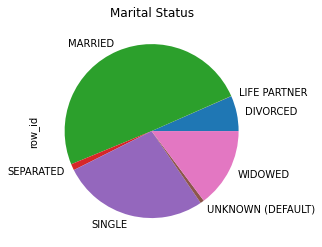

In [10]:
df_adm.columns = map(str.lower, df_adm.columns)
df_adm.groupby(['marital_status']).count()['row_id'].plot(kind='pie')
plt.title('Marital Status');

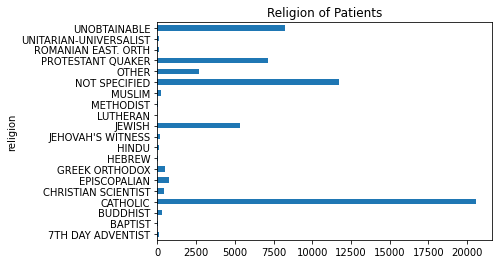

In [11]:
df_adm.groupby(['religion']).count()['row_id'].plot(kind = 'barh')
plt.title('Religion of Patients');

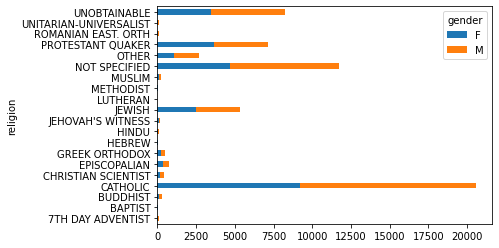

In [12]:
query = 'SELECT * FROM patients'
df_rel = wr.athena.read_sql_query(query, database=database)
df_rel.columns = map(str.lower, df_rel.columns)
df_adm_rel = pd.merge(df_adm, df_rel, on = 'subject_id' , how = 'inner')
df_adm_rel.groupby(['religion','gender']).size().unstack().plot(kind="barh", stacked=True);

From the graphics above, it looks like that gender is fairly balanced amoung admisions, independent of religion. In addition, there are individuals from several marital status.

- What about the areas of the hospital where patients are discharged? What is the distribution of patients being discharged from the hospital in the different segments and areas?

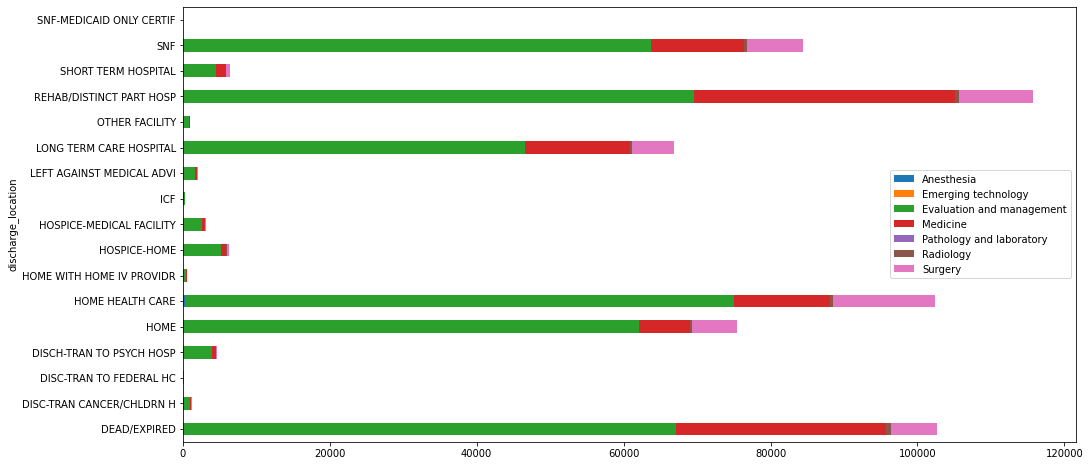

In [13]:
query = 'SELECT * FROM cptevents'
df_dis = wr.athena.read_sql_query(query, database=database)
df_dis.columns = map(str.lower, df_dis.columns)
df_adm_dis = pd.merge(df_adm, df_dis, on = 'hadm_id' , how = 'inner')
df_adm_dis.groupby(['discharge_location','sectionheader']).size().unstack().plot(kind="barh", stacked=True, figsize=(16,8))
plt.legend(loc='best');

## Analyzing missing values
The library [Missingno](https://github.com/ResidentMario/missingno) offers lots of useful visuals of the completeness of a dataset.

- In the admissions dataset, how the missing values of each column are related?

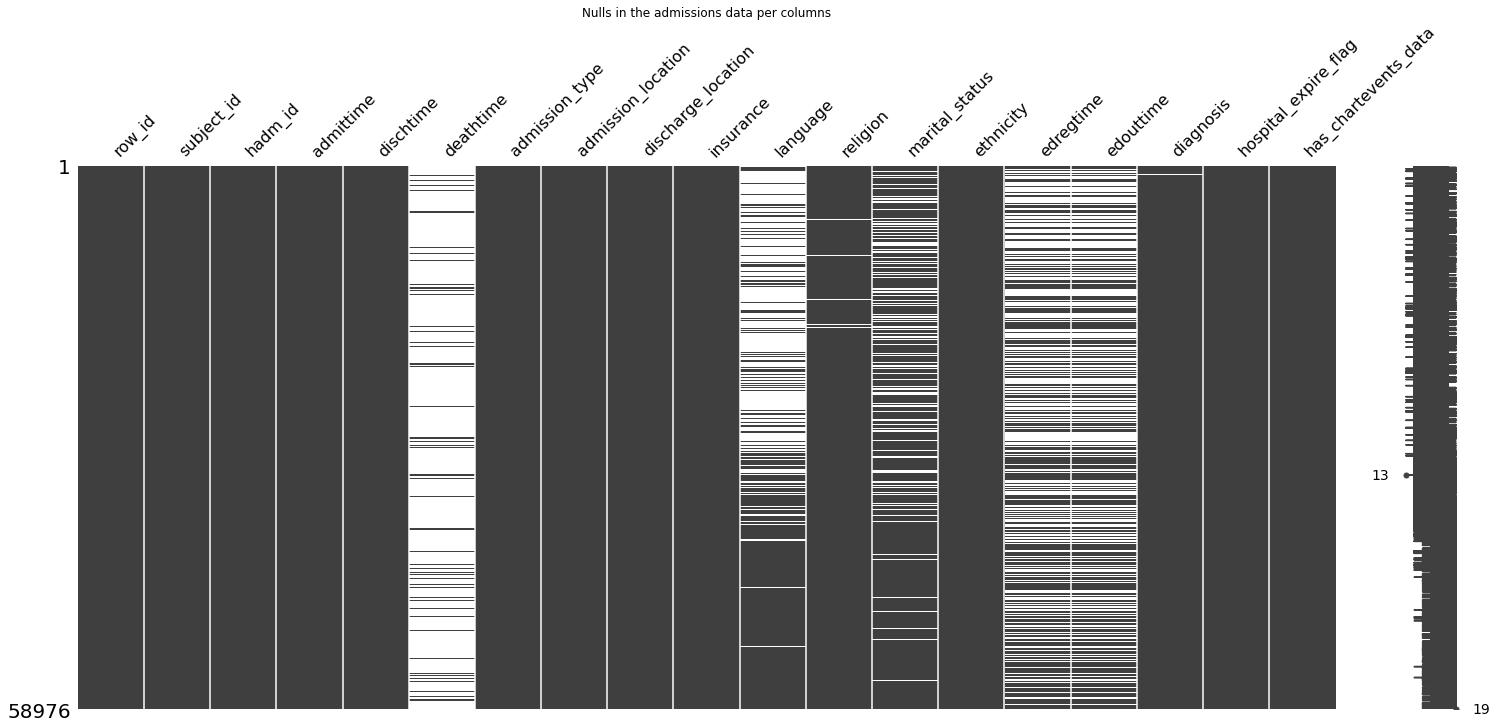

In [14]:
msno.matrix(df_adm)
plt.title('Nulls in the admissions data per columns');

The cool feature from scipy with Hierarchical clustering, we can cluster missing data points and understand how they are related. The Missingno makes it easy:

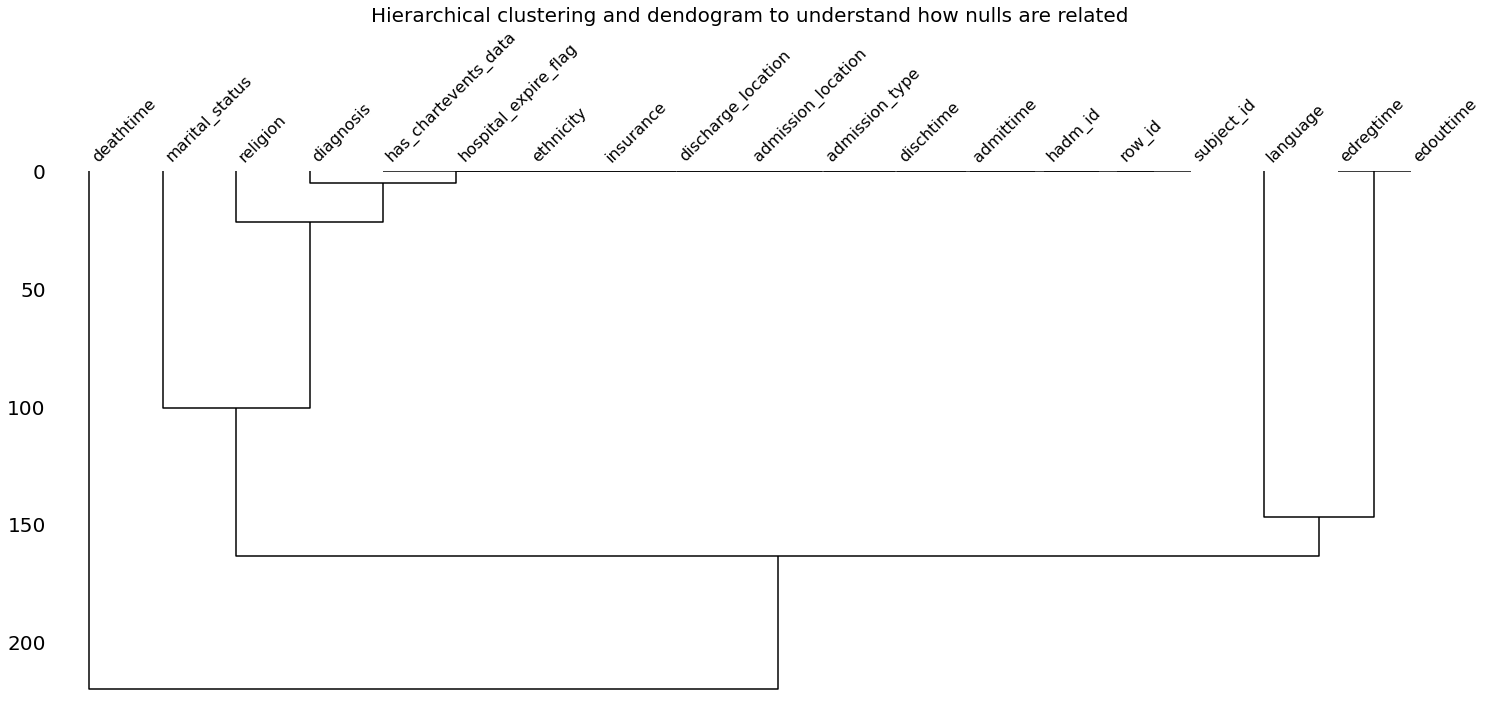

In [15]:
msno.dendrogram(df_adm)
plt.title('Hierarchical clustering and dendogram to understand how nulls are related', fontsize=20);

## Answering the second question
- What are the most common diagnosis for being admitted to the ICU?

To give an interesting visual, I use the [WordCloud library](https://github.com/amueller/word_cloud):

In [68]:
# Get text from the `diagnosis` column
diagnosis = str(df_adm['diagnosis'].values)
wordcloud = WordCloud().generate(diagnosis)

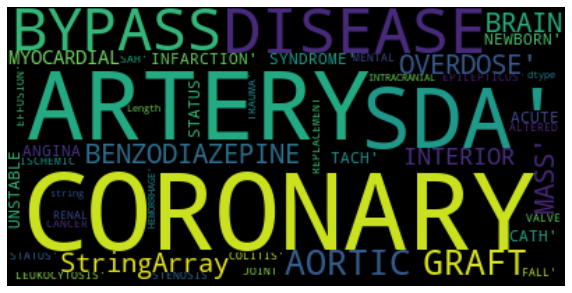

<Figure size 1440x1440 with 0 Axes>

In [69]:
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.figure(figsize=(20,20))
plt.show()

Looks like the Heart diseases are by far the most common (coronary, artery, aortic, infarction, myocardial). We can see all some other causes like oversodes, brain, and others.

### Analizing laboratory values vs outcome (mortality)

It's given that the 'Normal' ranges for lab values are:

Lab Value	|  Lower limit	|  Upper Limit	|  Units
--- | --- | --- | ---
Bicarbonate	| 22	| 32	| mEq/L
BUN	| 6	| 20 | mEq/L
Calcium	| 8.4	| 10.3	| mg/dL
Chloride	| 96	| 108	| mEq/L
Creatinine	| 0.4	| 1.1	| mEq/L
Hemoglobin	| 11.2	 | 15.7	| g/dL
Lactate	| 0.5	| 2	| mmol/L
Magnesium	| 1.6	| 2.6	| mg/dL
Phosphate	| 2.7	| 4.5	| mg/dL
Platelet count	| 150	| 400	| K/uL
Potassium	| 3.3	| 5.1	| mEq/L
Sodium	| 133	| 145	| mEq/L


In [19]:
lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }

In [20]:
query = \
"""
WITH pvt AS (
  SELECT ie.subject_id, ie.hadm_id, ie.outtime, ie.icustay_id, le.charttime, ad.deathtime
  , CASE when ad.deathtime between ie.intime and ie.outtime THEN 1 ELSE 0 END AS mort_icu
  , CASE when ad.deathtime between ad.admittime and ad.dischtime THEN 1 ELSE 0 END AS mort_hosp
  -- here we assign labels to ITEMIDs
  -- this also fuses together multiple ITEMIDs containing the same data
  , CASE
        when le.itemid = 50868 then 'ANION GAP'
        when le.itemid = 50862 then 'ALBUMIN'
        when le.itemid = 50882 then 'BICARBONATE'
        when le.itemid = 50885 then 'BILIRUBIN'
        when le.itemid = 50912 then 'CREATININE'
        when le.itemid = 50806 then 'CHLORIDE'
        when le.itemid = 50902 then 'CHLORIDE'
        when itemid = 50809 then 'GLUCOSE'
        when itemid = 50931 then 'GLUCOSE'
        when itemid = 50810 then 'HEMATOCRIT'
        when itemid = 51221 then 'HEMATOCRIT'
        when itemid = 50811 then 'HEMOGLOBIN'
        when itemid = 51222 then 'HEMOGLOBIN'
        when itemid = 50813 then 'LACTATE'
        when itemid = 50960 then 'MAGNESIUM'
        when itemid = 50970 then 'PHOSPHATE'
        when itemid = 51265 then 'PLATELET'
        when itemid = 50822 then 'POTASSIUM'
        when itemid = 50971 then 'POTASSIUM'
        when itemid = 51275 then 'PTT'
        when itemid = 51237 then 'INR'
        when itemid = 51274 then 'PT'
        when itemid = 50824 then 'SODIUM'
        when itemid = 50983 then 'SODIUM'
        when itemid = 51006 then 'BUN'
        when itemid = 51300 then 'WBC'
        when itemid = 51301 then 'WBC'
      ELSE null
      END AS label
  , -- add in some sanity checks on the values
    -- the where clause below requires all valuenum to be > 0, 
    -- so these are only upper limit checks
    CASE
      when le.itemid = 50862 and le.valuenum >    10 then null -- g/dL 'ALBUMIN'
      when le.itemid = 50868 and le.valuenum > 10000 then null -- mEq/L 'ANION GAP'
      when le.itemid = 50882 and le.valuenum > 10000 then null -- mEq/L 'BICARBONATE'
      when le.itemid = 50885 and le.valuenum >   150 then null -- mg/dL 'BILIRUBIN'
      when le.itemid = 50806 and le.valuenum > 10000 then null -- mEq/L 'CHLORIDE'
      when le.itemid = 50902 and le.valuenum > 10000 then null -- mEq/L 'CHLORIDE'
      when le.itemid = 50912 and le.valuenum >   150 then null -- mg/dL 'CREATININE'
      when le.itemid = 50809 and le.valuenum > 10000 then null -- mg/dL 'GLUCOSE'
      when le.itemid = 50931 and le.valuenum > 10000 then null -- mg/dL 'GLUCOSE'
      when le.itemid = 50810 and le.valuenum >   100 then null -- % 'HEMATOCRIT'
      when le.itemid = 51221 and le.valuenum >   100 then null -- % 'HEMATOCRIT'
      when le.itemid = 50811 and le.valuenum >    50 then null -- g/dL 'HEMOGLOBIN'
      when le.itemid = 51222 and le.valuenum >    50 then null -- g/dL 'HEMOGLOBIN'
      when le.itemid = 50813 and le.valuenum >    50 then null -- mmol/L 'LACTATE'
      when le.itemid = 50960 and le.valuenum >    60 then null -- mmol/L 'MAGNESIUM'
      when le.itemid = 50970 and le.valuenum >    60 then null -- mg/dL 'PHOSPHATE'
      when le.itemid = 51265 and le.valuenum > 10000 then null -- K/uL 'PLATELET'
      when le.itemid = 50822 and le.valuenum >    30 then null -- mEq/L 'POTASSIUM'
      when le.itemid = 50971 and le.valuenum >    30 then null -- mEq/L 'POTASSIUM'
      when le.itemid = 51275 and le.valuenum >   150 then null -- sec 'PTT'
      when le.itemid = 51237 and le.valuenum >    50 then null -- 'INR'
      when le.itemid = 51274 and le.valuenum >   150 then null -- sec 'PT'
      when le.itemid = 50824 and le.valuenum >   200 then null -- mEq/L == mmol/L 'SODIUM'
      when le.itemid = 50983 and le.valuenum >   200 then null -- mEq/L == mmol/L 'SODIUM'
      when le.itemid = 51006 and le.valuenum >   300 then null -- 'BUN'
      when le.itemid = 51300 and le.valuenum >  1000 then null -- 'WBC'
      when le.itemid = 51301 and le.valuenum >  1000 then null -- 'WBC'
    ELSE le.valuenum
    END AS valuenum
  FROM icustays ie

  LEFT JOIN labevents le
    ON le.subject_id = ie.subject_id 
    AND le.hadm_id = ie.hadm_id
    AND le.charttime between (ie.intime - interval '6' hour) 
    AND (ie.intime + interval '1' day)
    AND le.itemid IN
    (
      -- comment is: LABEL | CATEGORY | FLUID | NUMBER OF ROWS IN LABEVENTS
      50868, -- ANION GAP | CHEMISTRY | BLOOD | 769895
      50862, -- ALBUMIN | CHEMISTRY | BLOOD | 146697
      50882, -- BICARBONATE | CHEMISTRY | BLOOD | 780733
      50885, -- BILIRUBIN, TOTAL | CHEMISTRY | BLOOD | 238277
      50912, -- CREATININE | CHEMISTRY | BLOOD | 797476
      50902, -- CHLORIDE | CHEMISTRY | BLOOD | 795568
      50806, -- CHLORIDE, WHOLE BLOOD | BLOOD GAS | BLOOD | 48187
      50931, -- GLUCOSE | CHEMISTRY | BLOOD | 748981
      50809, -- GLUCOSE | BLOOD GAS | BLOOD | 196734
      51221, -- HEMATOCRIT | HEMATOLOGY | BLOOD | 881846
      50810, -- HEMATOCRIT, CALCULATED | BLOOD GAS | BLOOD | 89715
      51222, -- HEMOGLOBIN | HEMATOLOGY | BLOOD | 752523
      50811, -- HEMOGLOBIN | BLOOD GAS | BLOOD | 89712
      50813, -- LACTATE | BLOOD GAS | BLOOD | 187124
      50960, -- MAGNESIUM | CHEMISTRY | BLOOD | 664191
      50970, -- PHOSPHATE | CHEMISTRY | BLOOD | 590524
      51265, -- PLATELET COUNT | HEMATOLOGY | BLOOD | 778444
      50971, -- POTASSIUM | CHEMISTRY | BLOOD | 845825
      50822, -- POTASSIUM, WHOLE BLOOD | BLOOD GAS | BLOOD | 192946
      51275, -- PTT | HEMATOLOGY | BLOOD | 474937
      51237, -- INR(PT) | HEMATOLOGY | BLOOD | 471183
      51274, -- PT | HEMATOLOGY | BLOOD | 469090
      50983, -- SODIUM | CHEMISTRY | BLOOD | 808489
      50824, -- SODIUM, WHOLE BLOOD | BLOOD GAS | BLOOD | 71503
      51006, -- UREA NITROGEN | CHEMISTRY | BLOOD | 791925
      51301, -- WHITE BLOOD CELLS | HEMATOLOGY | BLOOD | 753301
      51300  -- WBC COUNT | HEMATOLOGY | BLOOD | 2371
    )
    AND le.valuenum IS NOT null 
    AND le.valuenum > 0 -- lab values cannot be 0 and cannot be negative
    
    LEFT JOIN admissions ad
    ON ie.subject_id = ad.subject_id
    AND ie.hadm_id = ad.hadm_id
    
    -- WHERE ie.subject_id < 10000
    
),
ranked AS (
SELECT pvt.*, DENSE_RANK() OVER (PARTITION BY 
    pvt.subject_id, pvt.hadm_id,pvt.icustay_id,pvt.label ORDER BY pvt.charttime) as drank
FROM pvt
)
SELECT r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp
  , max(case when label = 'ANION GAP' then valuenum else null end) as ANIONGAP_1st
  , max(case when label = 'ALBUMIN' then valuenum else null end) as ALBUMIN_1st
  , max(case when label = 'BICARBONATE' then valuenum else null end) as BICARBONATE_1st
  , max(case when label = 'BILIRUBIN' then valuenum else null end) as BILIRUBIN_1st
  , max(case when label = 'CREATININE' then valuenum else null end) as CREATININE_1st
  , max(case when label = 'CHLORIDE' then valuenum else null end) as CHLORIDE_1st
  , max(case when label = 'GLUCOSE' then valuenum else null end) as GLUCOSE_1st
  , max(case when label = 'HEMATOCRIT' then valuenum else null end) as HEMATOCRIT_1st
  , max(case when label = 'HEMOGLOBIN' then valuenum else null end) as HEMOGLOBIN_1st
  , max(case when label = 'LACTATE' then valuenum else null end) as LACTATE_1st
  , max(case when label = 'MAGNESIUM' then valuenum else null end) as MAGNESIUM_1st
  , max(case when label = 'PHOSPHATE' then valuenum else null end) as PHOSPHATE_1st
  , max(case when label = 'PLATELET' then valuenum else null end) as PLATELET_1st
  , max(case when label = 'POTASSIUM' then valuenum else null end) as POTASSIUM_1st
  , max(case when label = 'PTT' then valuenum else null end) as PTT_1st
  , max(case when label = 'INR' then valuenum else null end) as INR_1st
  , max(case when label = 'PT' then valuenum else null end) as PT_1st
  , max(case when label = 'SODIUM' then valuenum else null end) as SODIUM_1st
  , max(case when label = 'BUN' then valuenum else null end) as BUN_1st
  , max(case when label = 'WBC' then valuenum else null end) as WBC_1st

FROM ranked r
WHERE r.drank = 1
GROUP BY r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp, r.drank
ORDER BY r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp, r.drank;
"""

In [ ]:
data = wr.athena.read_sql_query(query, database)
data.head()  #(omitting output because of individual records)

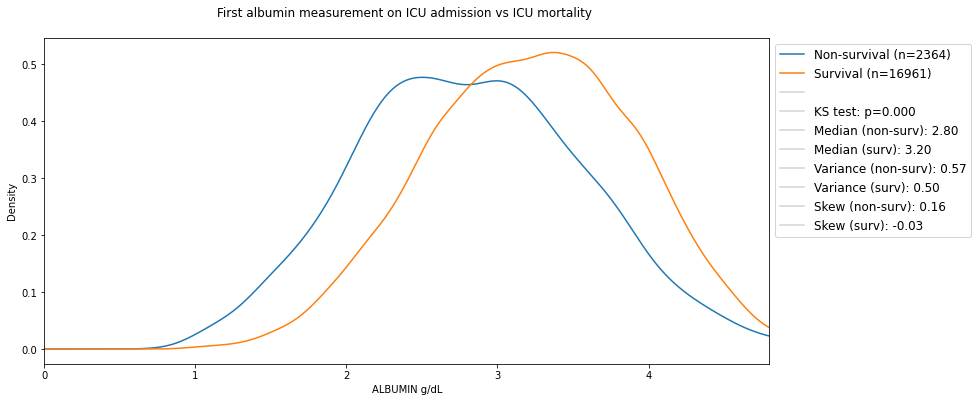

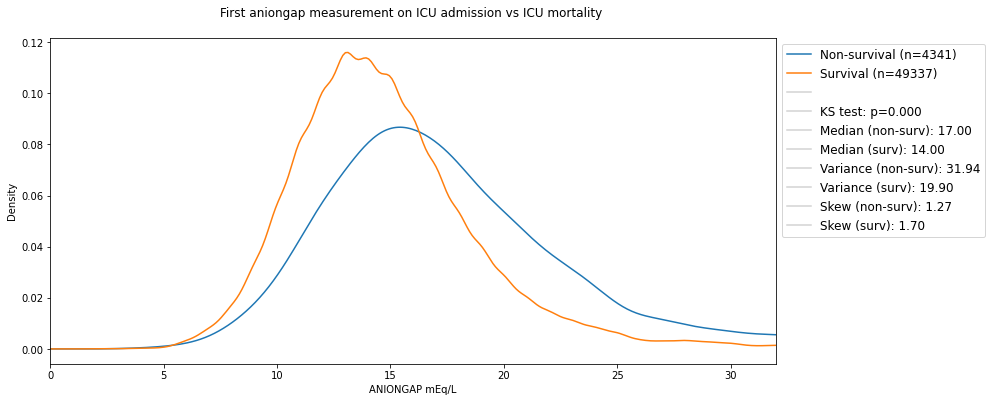

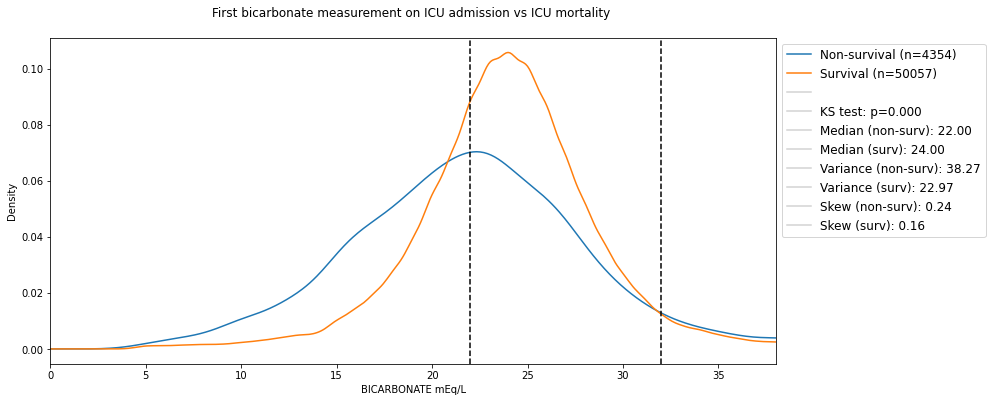

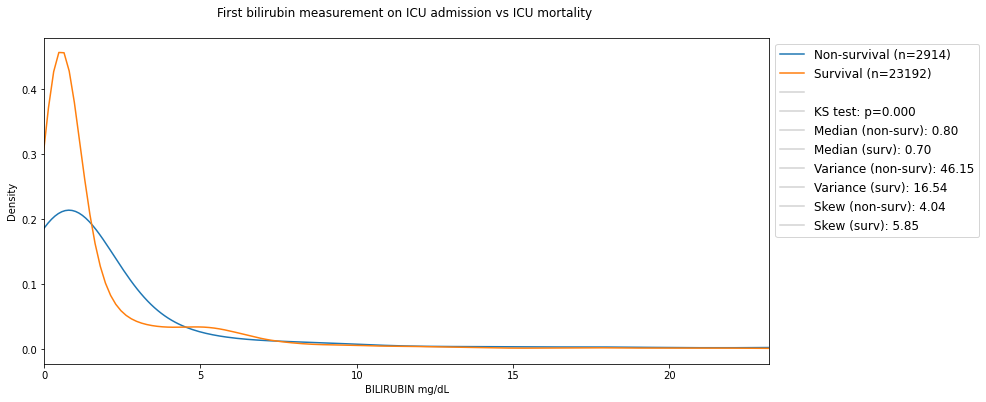

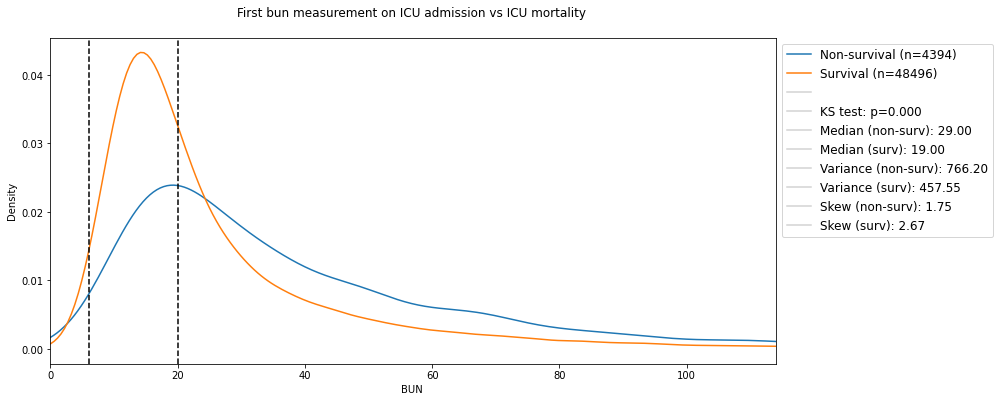

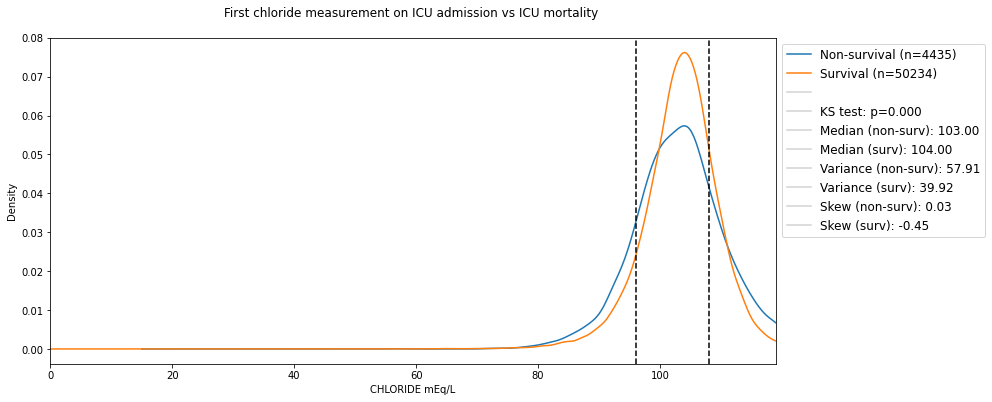

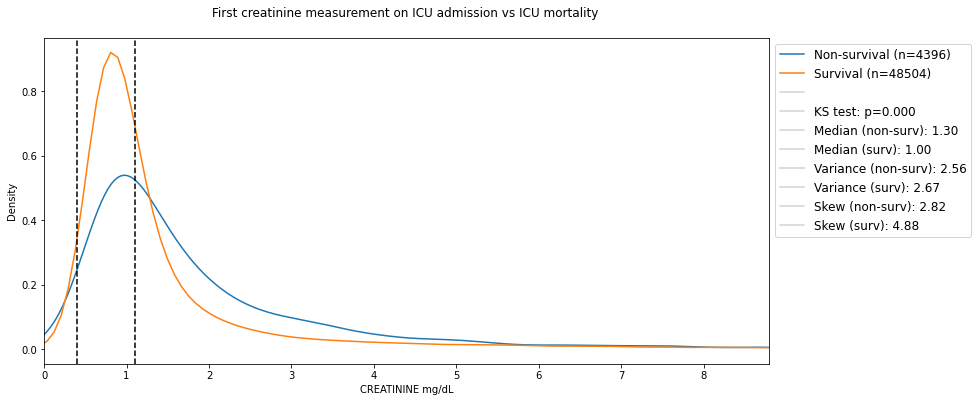

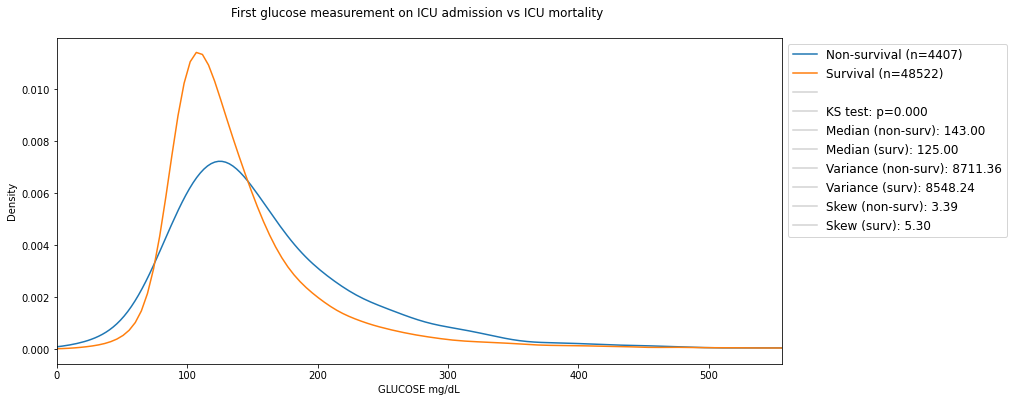

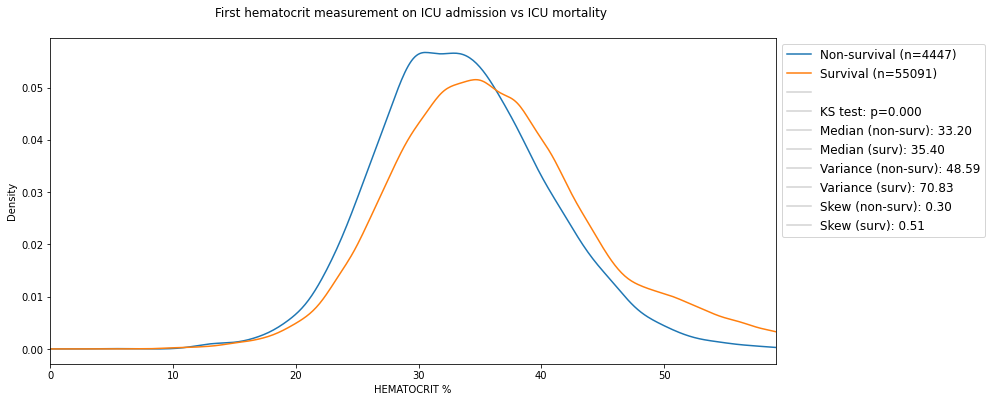

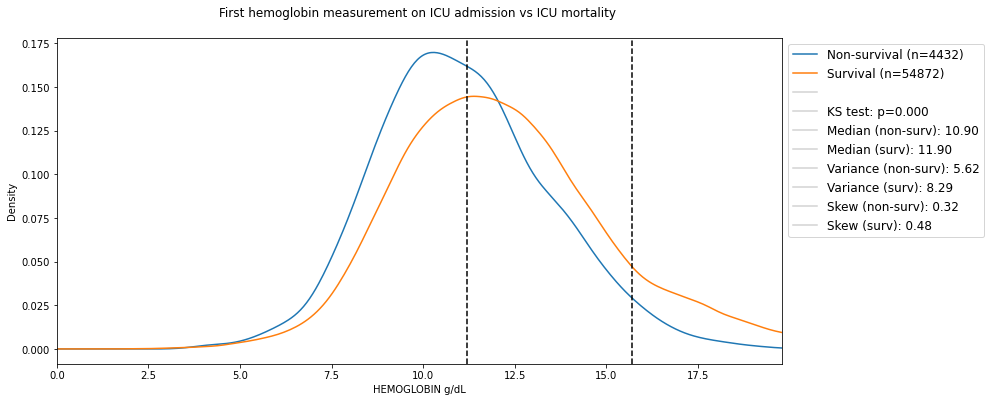

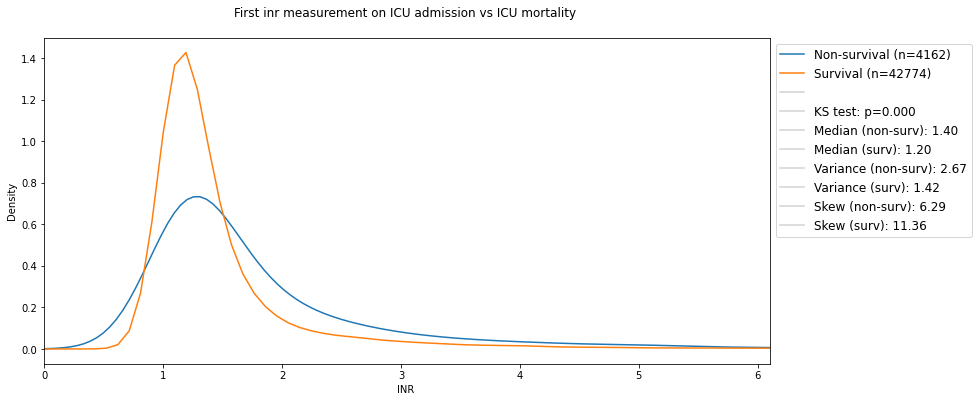

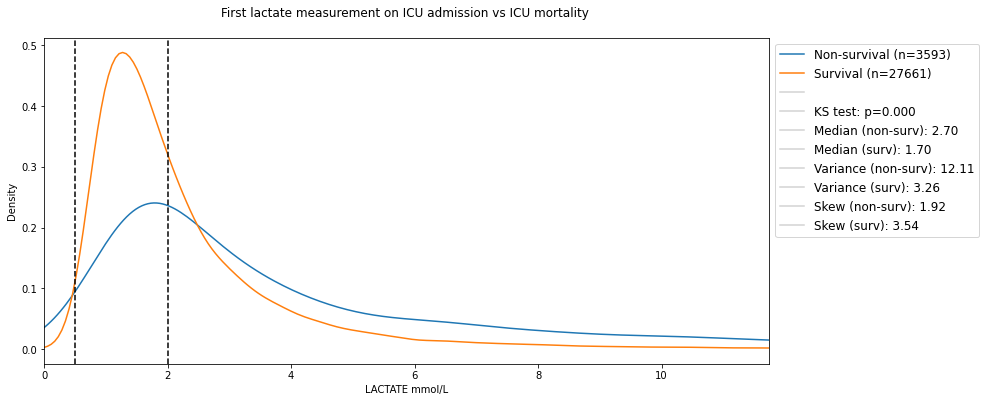

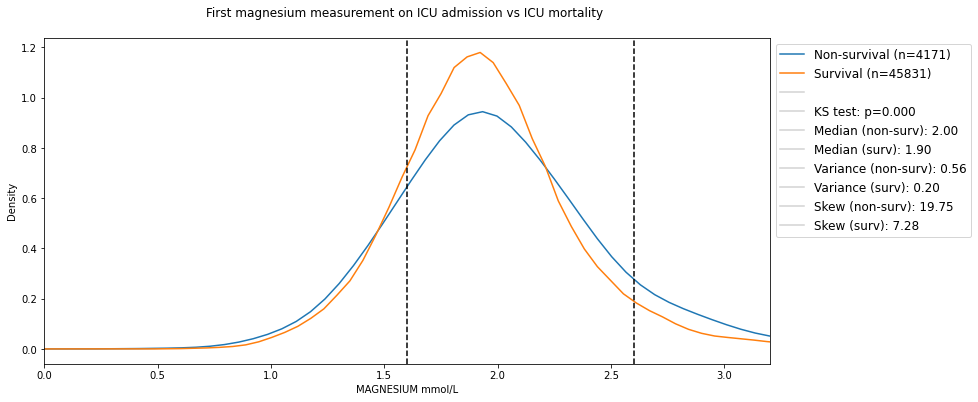

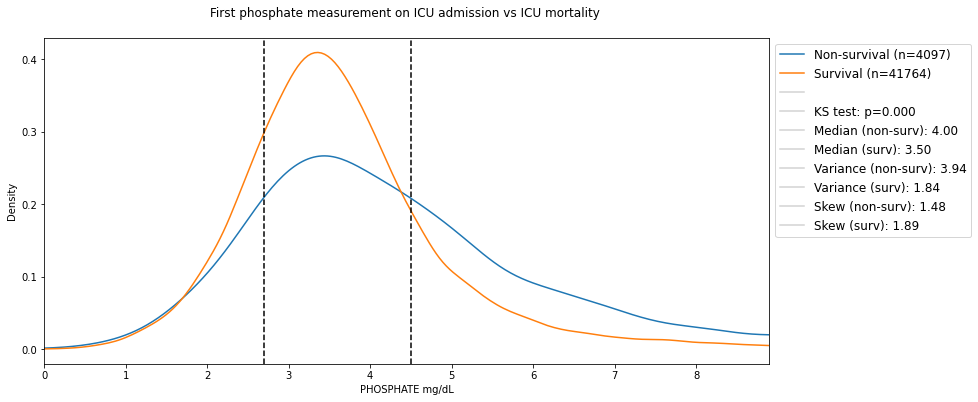

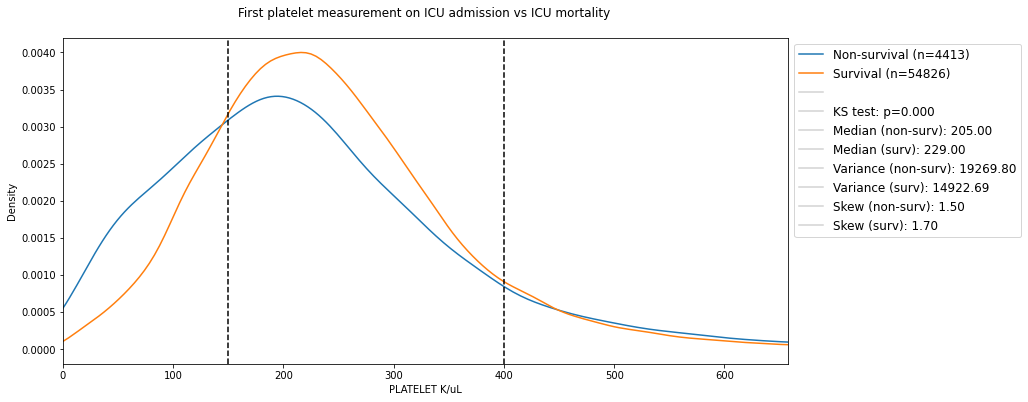

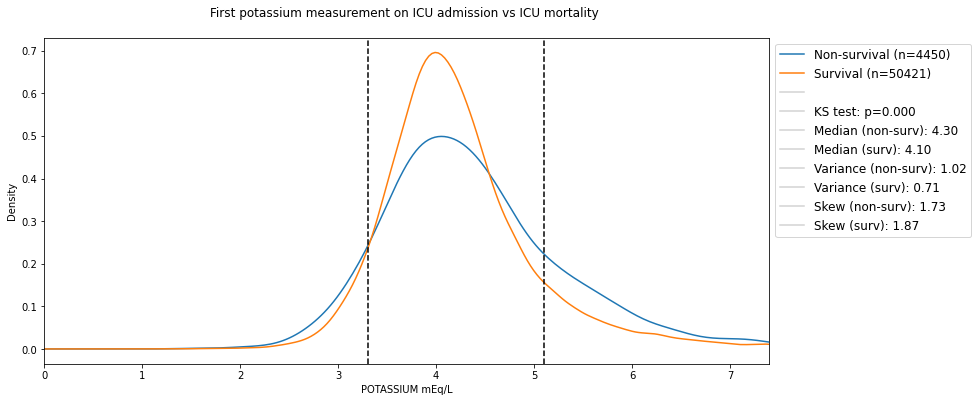

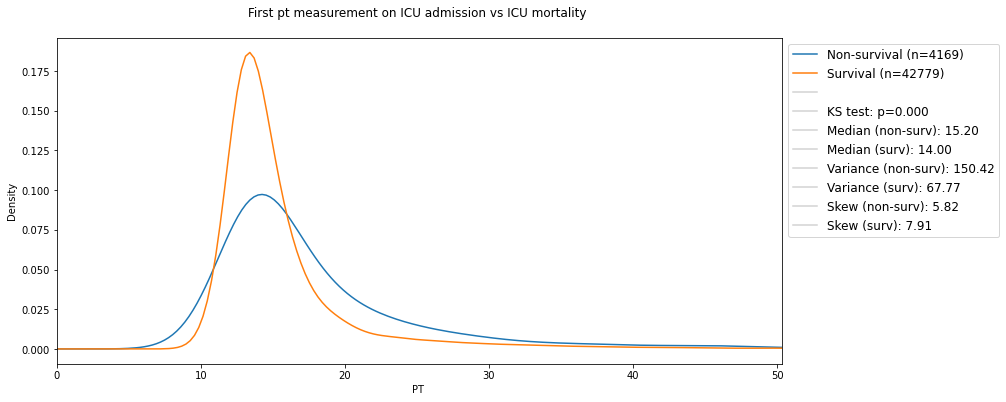

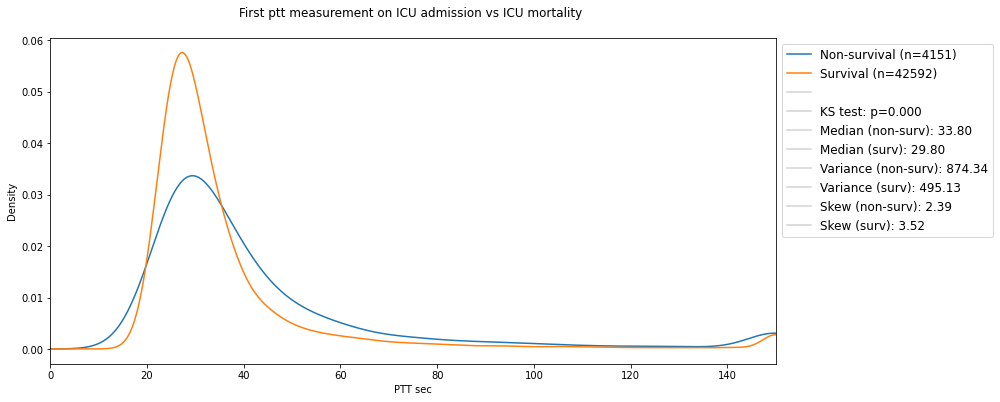

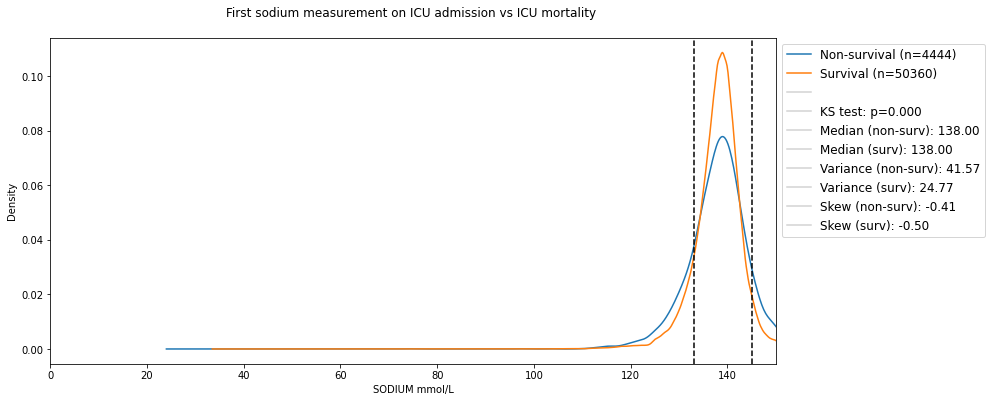

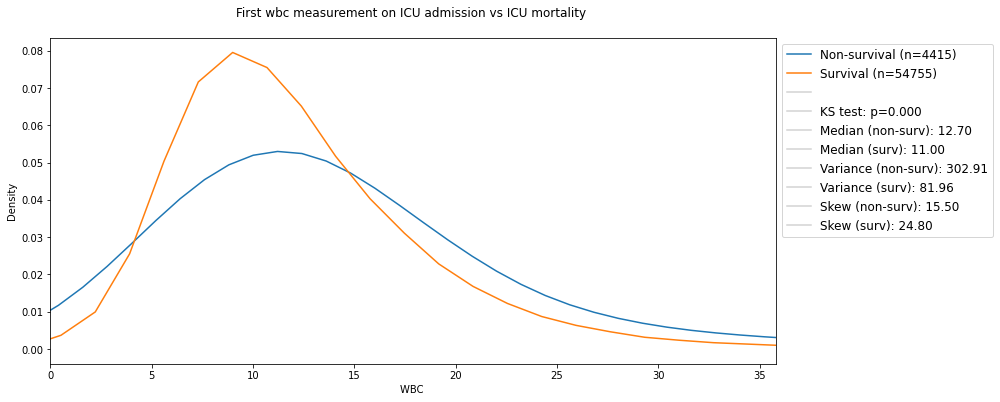

In [22]:
# Laboratory measurement on ICU admission vs ICU mortality

labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

for l, u in iter(sorted(labs.items())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l.lower()+'_1st'][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l.lower()+'_1st'].quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    

In [ ]:
# Risk of patients with labs outside the normal range
data.loc[data['mort_icu']==0].head() #(omitting output because of individual records)

## Answering question 3
What is the average length of stay in the ICUs?

In [24]:
query = \
"""
SELECT i.subject_id, i.hadm_id, i.los
FROM icustays i;
"""

In [25]:
data = wr.athena.read_sql_query(query, database=database)

In [ ]:
data.head() #(omitting output because of individual records)

In [27]:
# Compute the median Length of Stays (LOS)
avg_los = data.los.median()
print(avg_los)

2.09225


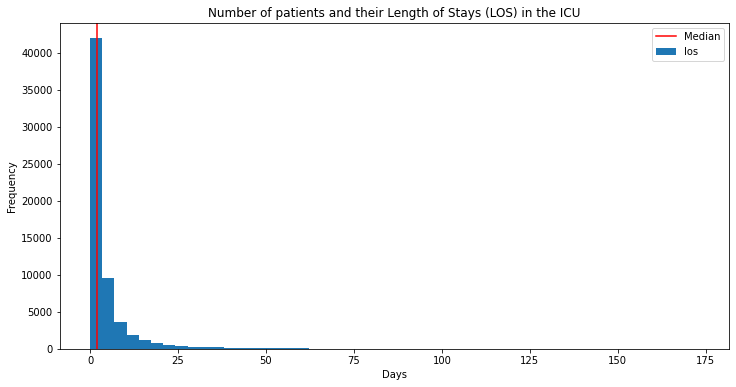

In [28]:
# Plot the distribution
data.los.plot(kind='hist', bins=50, figsize=(12,6))
plt.title('Number of patients and their Length of Stays (LOS) in the ICU')
plt.axvline(avg_los, label='Median', color='r')
plt.legend()
plt.xlabel('Days');

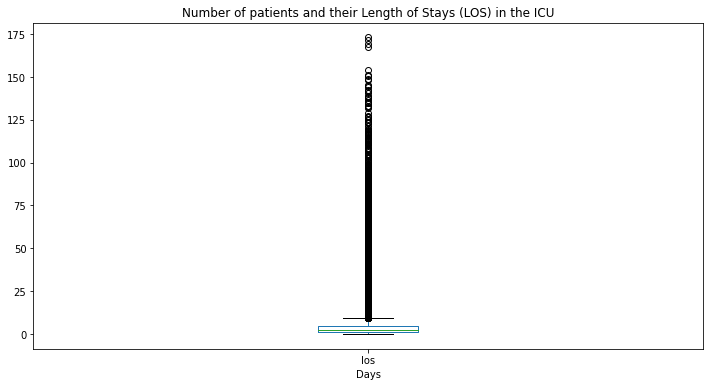

In [73]:
data.los.plot(kind='box', figsize=(12,6))
plt.title('Number of patients and their Length of Stays (LOS) in the ICU')
plt.xlabel('Days');

As I couldn't expect (probably from my lack of knowledge in the healthcare field) most of the patients stay just a few days in the ICUs.

## What about a single patient
- How could be his/her evolution in the ICU?

In [29]:
query = """
SELECT subject_id, hadm_id, admittime, dischtime, admission_type, diagnosis
FROM admissions
"""

In [30]:
df = wr.athena.read_sql_query(query, database=database)

In [ ]:
# Display the first few rows (omitting output because of individual records)
df.head()

### Load the chartevents data

- The chartevents table contains data charted at the patient bedside. It includes variables such as heart rate, respiratory rate, temperature, and so on.
- We'll begin by loading the chartevents data for a single patient.

In [ ]:
query = """
SELECT de.icustay_id, de.charttime
FROM chartevents de
LIMIT 10
"""
wr.athena.read_sql_query(query, database=database) # omitting output because of individual records

In [ ]:
query = """
SELECT ie.icustay_id, ie.intime
FROM icustays ie
LIMIT 10
"""
wr.athena.read_sql_query(query, database=database) # omitting output because of individual records

In [34]:
wr.catalog.table(database,'chartevents')

,Column Name,Type,Partition,Comment
0,row_id,int,False,
1,subject_id,int,False,
2,hadm_id,int,False,
3,icustay_id,int,False,
4,itemid,int,False,
5,charttime,timestamp,False,
6,storetime,timestamp,False,
7,cgid,int,False,
8,value,string,False,
9,valuenum,double,False,


In [ ]:
query = """
SELECT de.icustay_id
  , ie.intime
  , de.charttime
  , date_diff('second', ie.intime, de.charttime)/3600.0 as HOURS
  , di.label
  , de.value
  , de.valuenum
  , de.valueuom
FROM chartevents de
INNER join d_items di
ON de.itemid = di.itemid
INNER join icustays ie
ON de.icustay_id = ie.icustay_id
WHERE de.icustay_id = --<OMITTED_ID>
ORDER BY charttime;
"""

ce = wr.athena.read_sql_query(query, database=database)
ce.head() # omitting output because of individual records

- How did the patients heart rate change over time?

In [36]:
# Check rate columns
ce.label[ce.label.str.endswith('Rate')].unique()

<StringArray>
['Respiratory Rate', 'Heart Rate']
Length: 2, dtype: string

In [37]:
# Check alarms
ce.label[ce.label.str.contains('Alarm')].unique()

<StringArray>
['Non-Invasive Blood Pressure Alarm - High',
                   'Heart Rate Alarm - Low',
  'O2 Saturation Pulseoxymetry Alarm - Low',
                                'Alarms On',
                  'Heart rate Alarm - High',
                         'NBP Alarm Source',
 'O2 Saturation Pulseoxymetry Alarm - High',
  'Non-Invasive Blood Pressure Alarm - Low',
                         'Resp Alarm - Low',
                        'Resp Alarm - High']
Length: 10, dtype: string

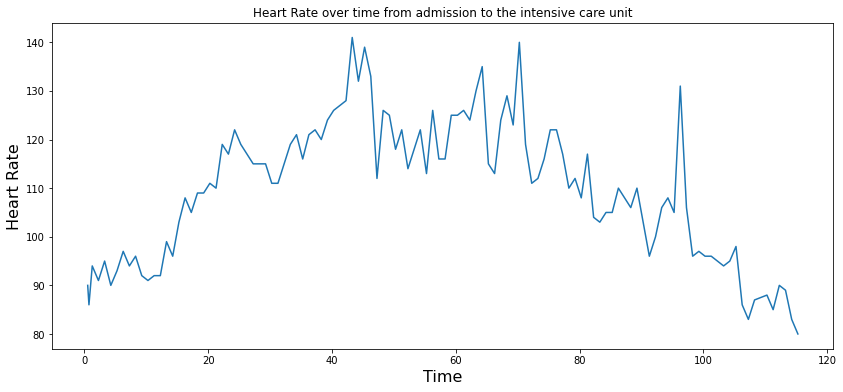

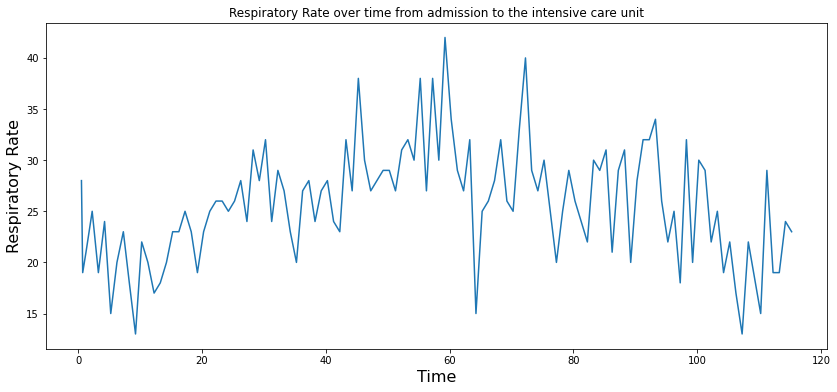

In [39]:
for col in ['Heart Rate', 'Respiratory Rate']:
    # Set x equal to the times
    x_hr = ce.hours[ce.label==col]

    # Set y equal to the heart rates
    y_hr = ce.valuenum[ce.label==col]

    # Plot time against heart rate
    plt.figure(figsize=(14, 6))
    plt.plot(x_hr,y_hr)


    plt.xlabel('Time',fontsize=16)
    plt.ylabel(col,fontsize=16)
    plt.title(f'{col} over time from admission to the intensive care unit');

- Did the patient's vital signs breach any alarm thresholds?

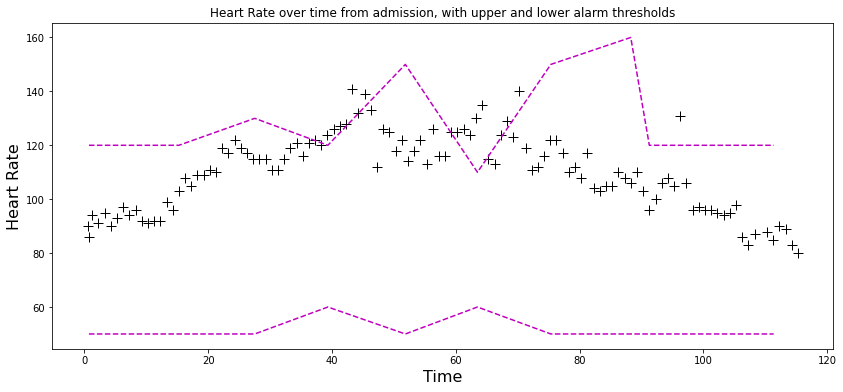

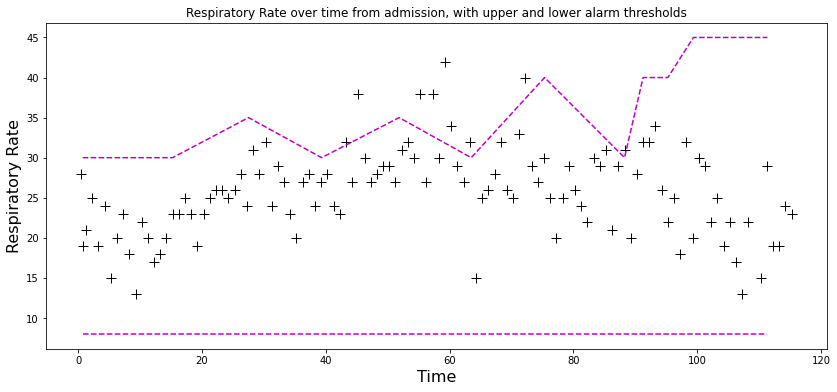

In [40]:
for metric, alarm in [('Heart Rate', 'Heart Rate Alarm'),('Respiratory Rate', 'Resp Alarm')]:
    plt.figure(figsize=(14, 6))
    
    plt.plot(ce.hours[ce.label==metric], 
             ce.valuenum[ce.label==metric],
             'k+', markersize=10, linewidth=4)
    
    if alarm=='Heart Rate Alarm':
        alarm_h = alarm.replace('Rate', 'rate')
    else:
        alarm_h = alarm

    plt.plot(ce.hours[ce.label==alarm_h+' - High'], 
             ce.valuenum[ce.label==alarm_h+' - High'],
             'm--')

    plt.plot(ce.hours[ce.label==alarm+' - Low'], 
             ce.valuenum[ce.label==alarm+' - Low'],
             'm--')

    plt.xlabel('Time',fontsize=16)
    plt.ylabel(metric,fontsize=16)
    plt.title(f'{metric} over time from admission, with upper and lower alarm thresholds')
#     plt.ylim(0,55);


- What is patient's level of consciousness?

Glasgow Coma Scale (GCS) is a measure of consciousness and is useful here:

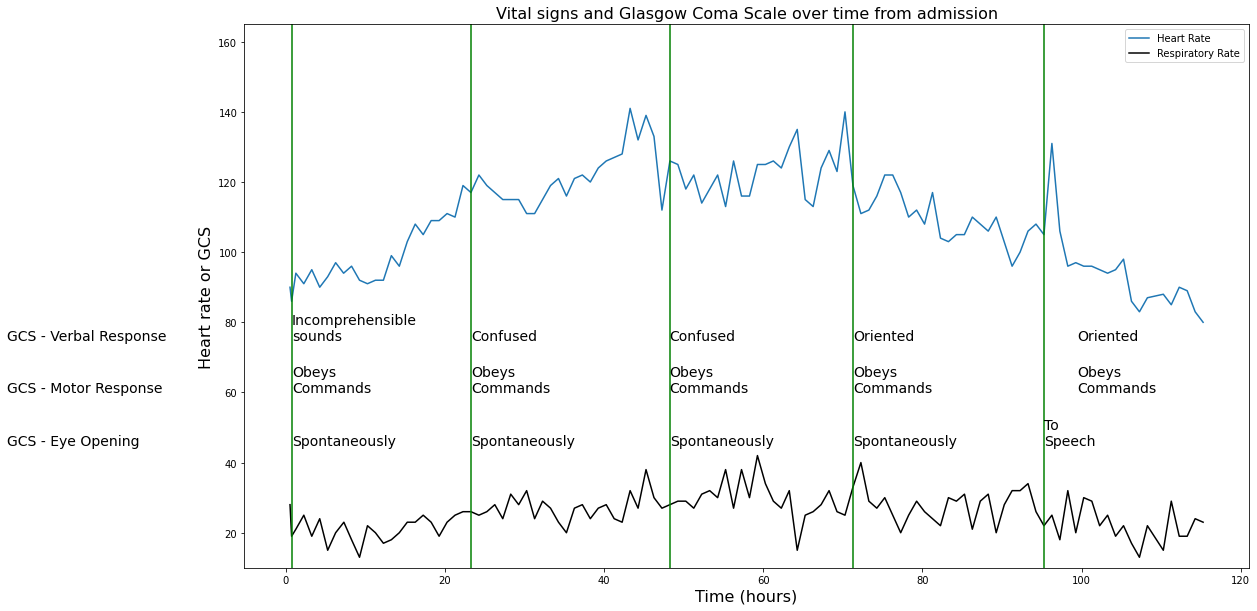

In [42]:
# Prepare the size of the figure
fig, ax = plt.subplots(figsize=(18, 10))

x_hr = ce.hours[ce.label=='Heart Rate']
y_hr = ce.valuenum[ce.label=='Heart Rate']
ax.plot(x_hr,y_hr, label='Heart Rate')
ax.legend()

x_rr = ce.hours[ce.label=='Respiratory Rate']
y_rr = ce.valuenum[ce.label=='Respiratory Rate']
ax.plot(x_rr, y_rr, 'k', markersize=6, label='Respiratory Rate')
ax.legend()

# Add a text label to the y-axis
x_s = -35
y_s = [45, 60, 75]
plt.text(x_s,y_s[0],'GCS - Eye Opening',fontsize=14)
plt.text(x_s,y_s[1],'GCS - Motor Response',fontsize=14)
plt.text(x_s,y_s[2],'GCS - Verbal Response',fontsize=14)   

# Iterate over list of GCS labels, plotting around 1 in 10 to avoid overlap
for i, txt in enumerate(ce.value[ce.label=='GCS - Eye Opening'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt.replace(' ','\n'), (ce.hours[ce.label=='GCS - Eye Opening'].values[i],y_s[0]),fontsize=14, annotation_clip=False)
        plt.axvline(ce.hours[ce.label=='GCS - Eye Opening'].values[i], color='g')
        
for i, txt in enumerate(ce.value[ce.label=='GCS - Motor Response'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt.replace(' ','\n'), (ce.hours[ce.label=='GCS - Motor Response'].values[i],y_s[1]),fontsize=14, annotation_clip=False)

for i, txt in enumerate(ce.value[ce.label=='GCS - Verbal Response'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt.replace(' ','\n'), (ce.hours[ce.label=='GCS - Verbal Response'].values[i],y_s[2]),fontsize=14, annotation_clip=False)

plt.title('Vital signs and Glasgow Coma Scale over time from admission',fontsize=16)

plt.xlabel('Time (hours)',fontsize=16)
plt.ylabel('Heart rate or GCS',fontsize=16)
plt.ylim(10,165);
